## Лабораторна робота 6. **Unsupervised Learning**

Оцінювання даної роботи буде ураховувати якість Ваших висновків та візуалізацій. При наявності ЛИШЕ коду та візуалізацій без роз"яснень, робота оцінюватися НЕ БУДЕ.  

Більшість поставлених в цій лабораторній роботі задач в майбутньому буде ставитись Вами самойстійно!

Під час виконання Вам дозволено користуватися будь-якими зручними для вас бібліотеками для візуалізації. 

Оформлення коментарів повинно проводитися в текстових комірках ноутбука з використанням синтаксису [LaTeX](https://en.wikibooks.org/wiki/LaTeX/Basics) для оформлення тексту та формул. 

Роботи ідентифіковані як ІДЕНТИЧНІ одразу отримують 0 балів.

## Кластерування  

В цій лабораторній роботі Ви будете вирішувати задачу класифікації БЕЗ вчителя. 

In [45]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline 

import os
import warnings


warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

**Завдання 0** 

Для початку необхідно завантажити вибірку `Mall_Customers` і перейменувати атрибути `Annual Income (k$)` в `Income`,`Spending Score (1-100)` в `SpendingScore`

In [46]:
customer_set = pd.read_csv("../Mall_Customers.csv", sep=",", encoding="utf-8", index_col=0)

In [47]:
customer_set = customer_set.rename(
    columns={
        "Annual Income (k$)": "Income", 
        "Spending Score (1-100)": "SpendingScore",
    }
)

In [48]:
customer_set.head()

,Gender,Age,Income,SpendingScore
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


**Завдання 1** 

Підготовка даних до опрацювання

* подивитись які атрибути містить вибірка; 
* вивести розмірність датасету;
* вивести основну статистичну інформацію по числовим змінним;  
* перевірити на наявність `NaN`.   

In [49]:
customer_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Gender         200 non-null    object
 1   Age            200 non-null    int64 
 2   Income         200 non-null    int64 
 3   SpendingScore  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [50]:
customer_set.shape

(200, 4)

In [51]:
customer_set.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
SpendingScore,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [52]:
customer_set.isnull().sum()

Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64

## EDA Mall Customers

**Завдання 2** 

Як Ви могли помітити по статистичній аналітиці вибірки вона містить змінну `CustomerID`. Ця змінна не впливає на аналіз даних тому її можна видалити.

In [53]:
# Я використав цю колонку яки індекс при вигрузці тому не видаляю її

**Завдання 3** 

Побудувати діаграми розподілу по змінним `Age` , `Income` та `SpendingScore`

<Axes: xlabel='SpendingScore', ylabel='Count'>

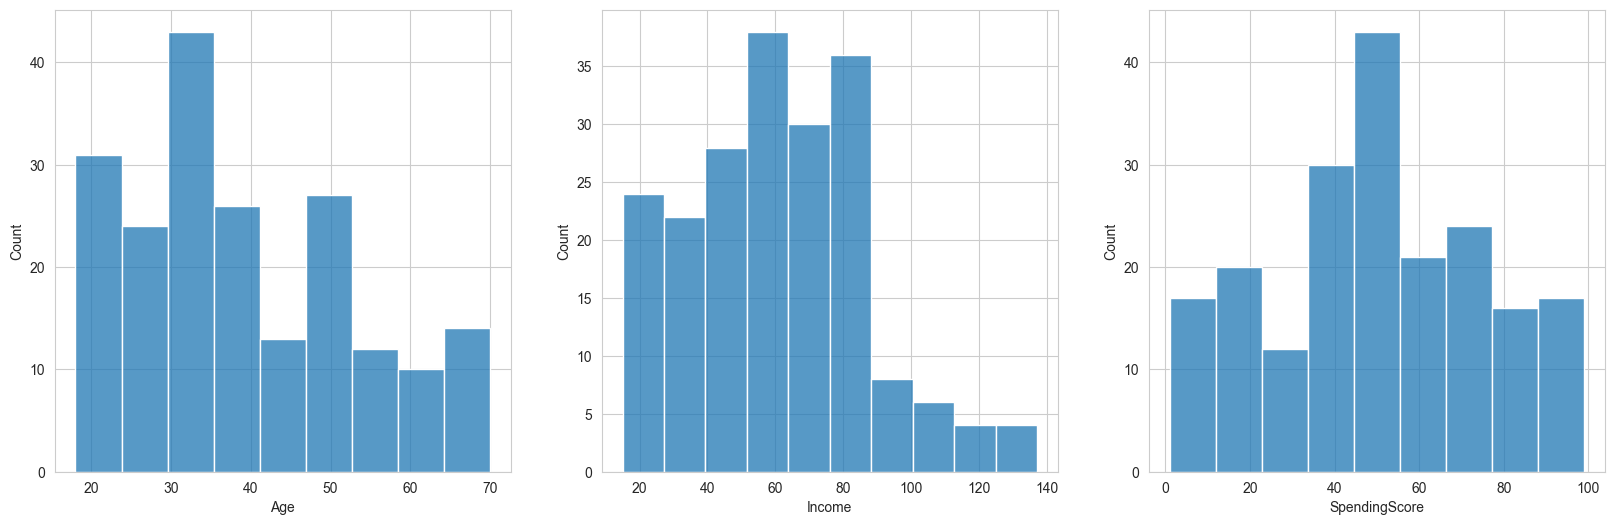

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(
    customer_set, 
    x="Age", 
    ax=ax[0]
)

sns.histplot(
    customer_set, 
    x="Income", 
    ax=ax[1]
)

sns.histplot(
    customer_set, 
    x="SpendingScore", 
    ax=ax[2]
)

**Завдання 4** 

Давайте подивимось на ці змінні `Age` , `Income` та `SpendingScore` відносно змінної `Gender`. 
* Побудуємо `pairplot` по всім змінним відностно змінної `Gender`:  
 
* Побудуємо `pairplot` використовуючи `sns.PairGrid` із заданими `(scatterplot)`, `(kdeplot)` та `(kdeplot, lw=1)` по відповідно правому верхньому куту, діагоналі і лівому нижньому кутут відносно змінної `Gender`:  
 

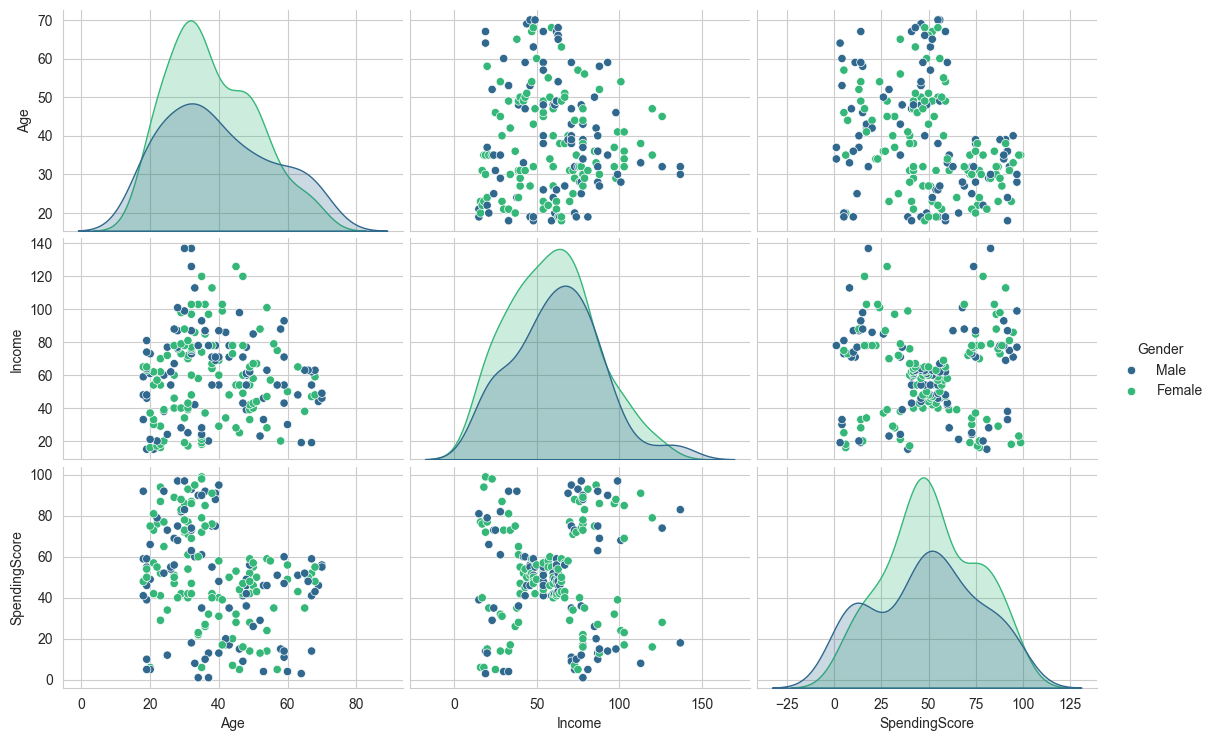

In [55]:
sns.pairplot(
    customer_set, 
    hue="Gender", 
    palette="viridis", 
    aspect=1.5
)

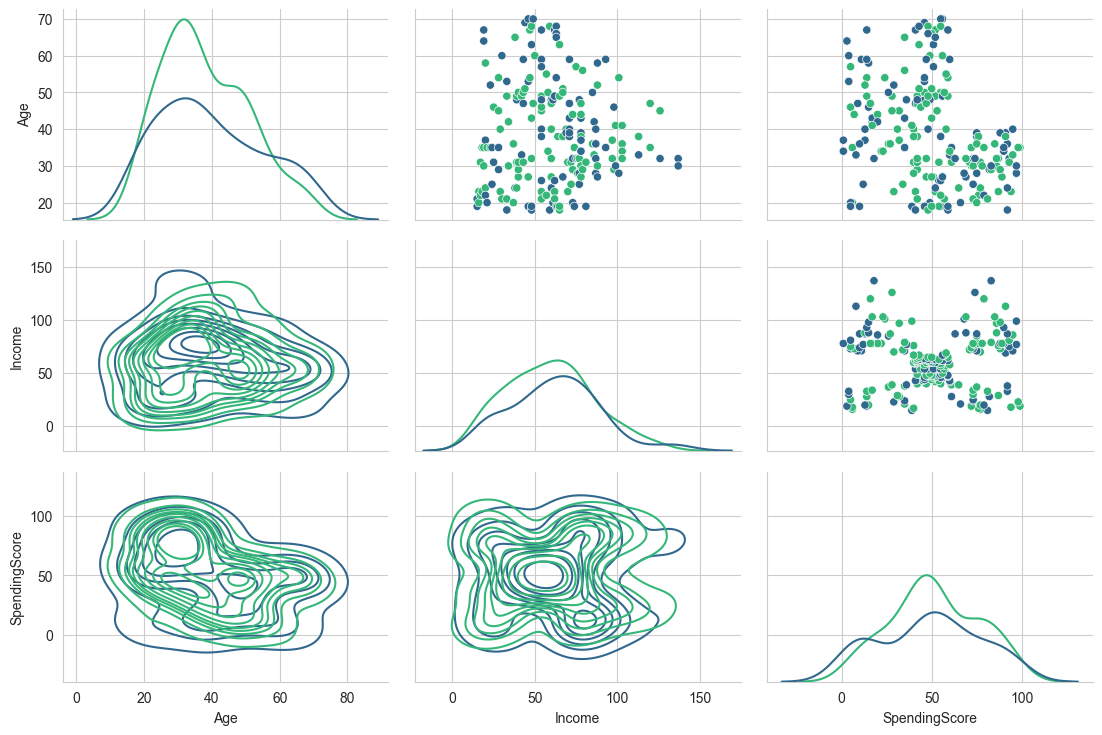

In [56]:
pairgrid = sns.PairGrid(
    customer_set, 
    hue="Gender", 
    palette="viridis", 
    aspect=1.5
)
pairgrid.map_upper(sns.scatterplot)
pairgrid.map_diag(sns.kdeplot)
pairgrid.map_lower(sns.kdeplot, lw=1)

**Висновки з 1-4 завдання (детальні)**

1. Датасет не має пропущених значень та містить колонки `Gender, Age, Income, SpendingScore`. Розмір датасету `(200, 4)`
3. По графіках можна побачити що більшість людей мають вік від 20 до 40 років з річним доходом приблизно 50-70 тисяч та витрачають найбільше від 40 до 60 тисяч. Графіки показують мультимодальний розподіл цих змінних.
4. `pairplot` по групуючій змінній `Gender` дозволяє нам побачити розділення на 5 груп в парі `SpendingScore` та `Income` також в `PairGrid` при `sns.kdeplot, lw=1` змінні `Income` та `Age` формують ледь помітні 3 групи.

**Завдання 5** 

Проаналізувати змінну `Gender`:
* вивести співвідношення по статям;
* побудувати `countplot` по `Gender`;  
* побудувати `pie`по `Gender".  

Gender
Female    56.0
Male      44.0
Name: proportion, dtype: float64

Співвідношення чоловіків до жінок: 


0.7857142857142856

([<matplotlib.patches.Wedge at 0x2603cc31b10>,
 [Text(-0.20611945413751356, 1.080515974257694, 'Female'),
  Text(0.20611945413751367, -1.080515974257694, 'Male')],
 [Text(-0.11242879316591647, 0.5893723495951058, '56.0%'),
  Text(0.11242879316591654, -0.5893723495951058, '44.0%')])

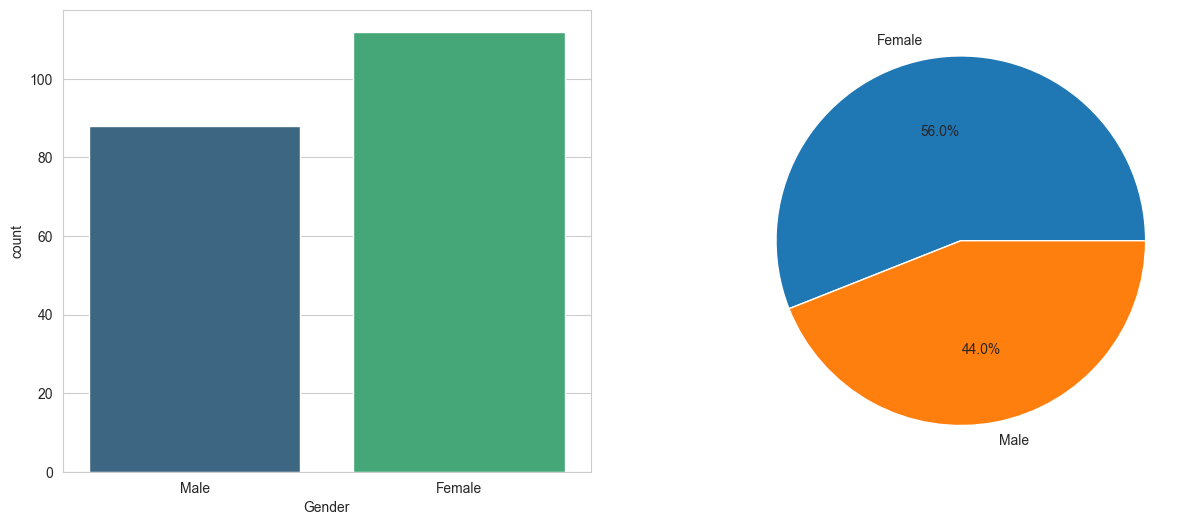

In [57]:
gender_percentages = customer_set["Gender"].value_counts(normalize=True) * 100
gender_ratio = gender_percentages["Male"] / gender_percentages["Female"]

display(gender_percentages)
print("Співвідношення чоловіків до жінок: ")
display(gender_ratio)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(
    customer_set, 
    x="Gender", 
    palette="viridis", 
    ax=ax[0],
)

ax[1].pie(
    gender_percentages, 
    labels=gender_percentages.index, 
    autopct="%1.1f%%",
)

**Завдання 6** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінних `Age` та `Income` відносно змінної `Gender` з різними параметрами:
*  подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`.

<Axes: xlabel='Income', ylabel='Count'>

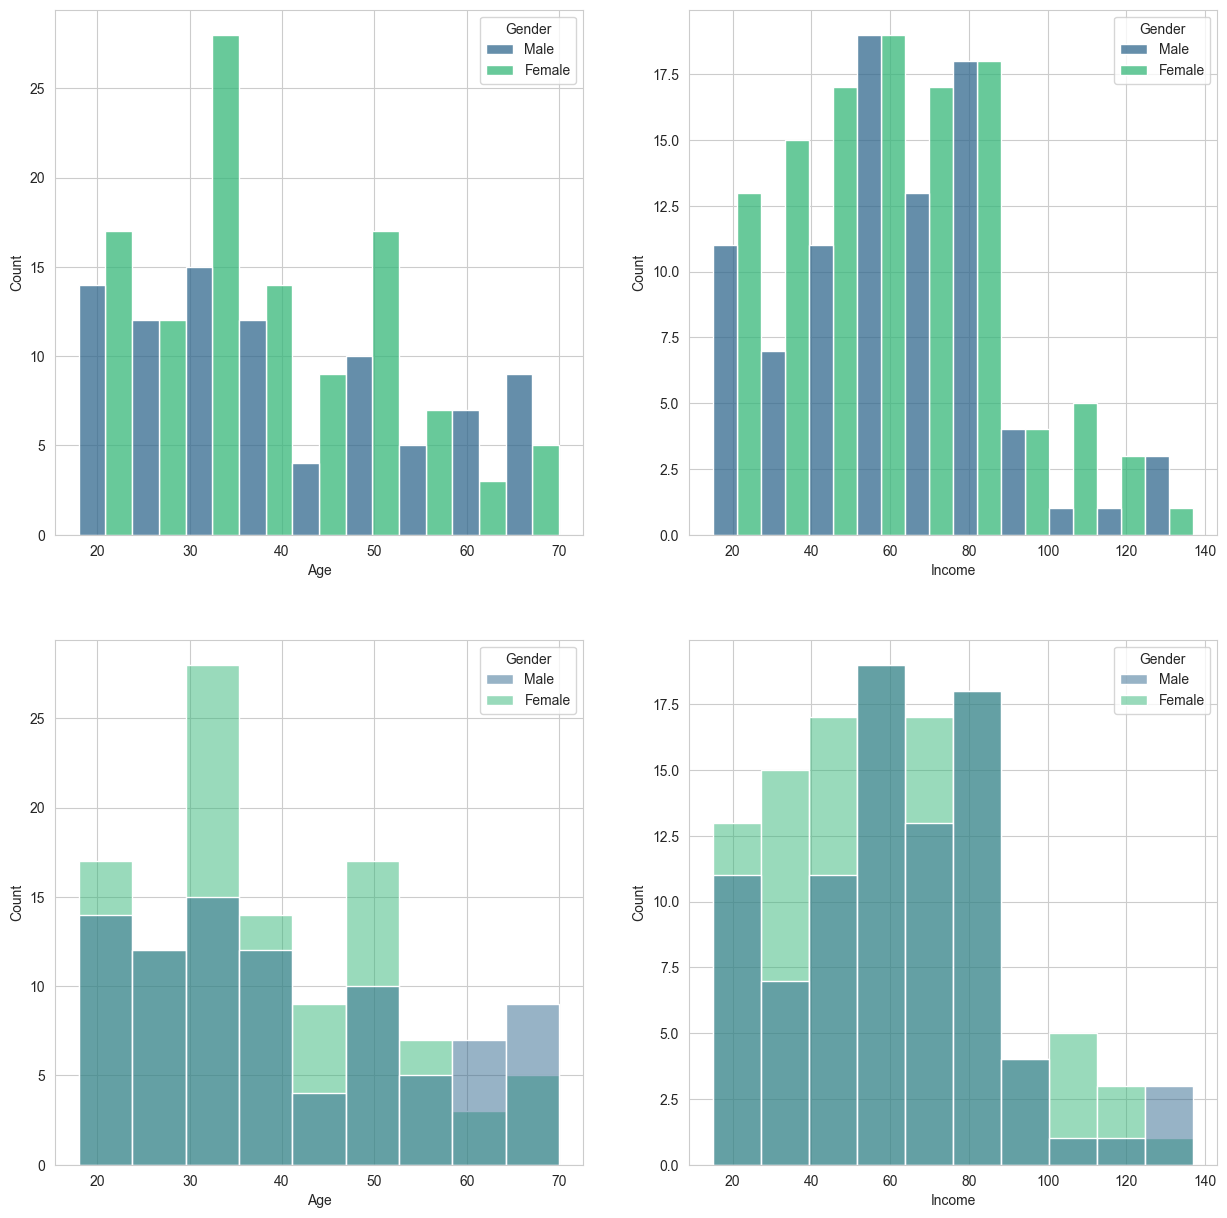

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

sns.histplot(
    customer_set, 
    x="Age", 
    hue="Gender", 
    multiple="dodge",
    palette="viridis", 
    ax=ax[0, 0], 
)

sns.histplot(
    customer_set, 
    x="Income", 
    hue="Gender", 
    multiple="dodge",
    palette="viridis", 
    ax=ax[0, 1], 
)

sns.histplot(
    customer_set, 
    x="Age", 
    hue="Gender", 
    multiple="layer",
    palette="viridis", 
    ax=ax[1, 0], 
)

sns.histplot(
    customer_set, 
    x="Income", 
    hue="Gender", 
    multiple="layer",
    palette="viridis", 
    ax=ax[1, 1], 
)

**Завдання 7** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінної `SpendingScore` відносно змінної `Gender` з різними параметрами:  
* подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`. 



<Axes: xlabel='SpendingScore', ylabel='Count'>

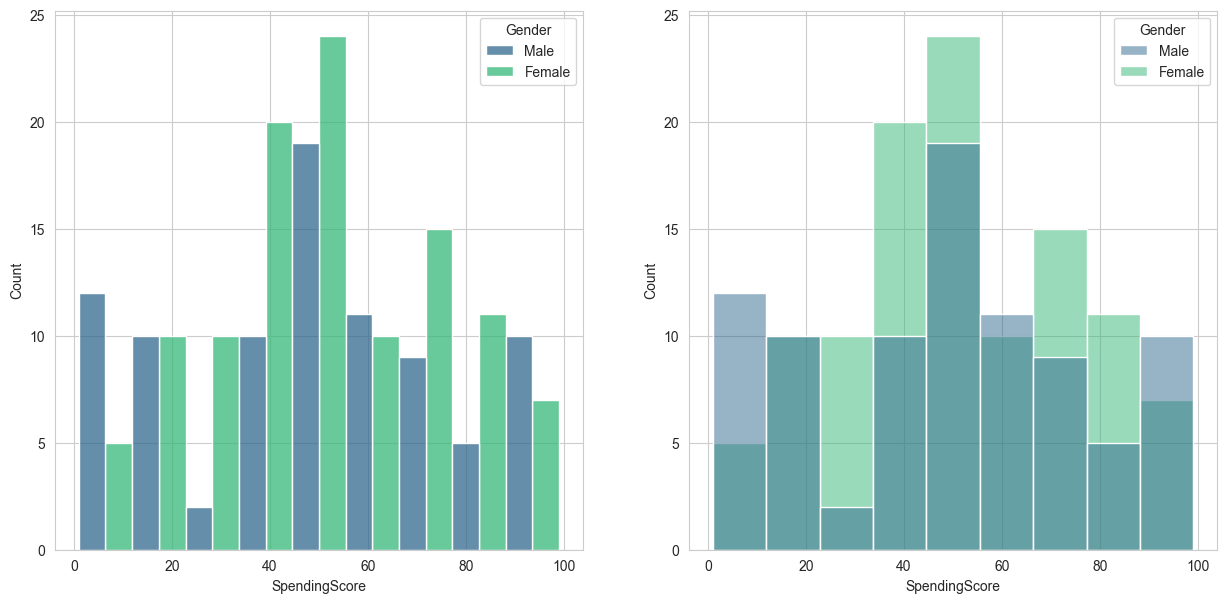

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(
    customer_set, 
    x="SpendingScore", 
    hue="Gender", 
    multiple="dodge",
    palette="viridis", 
    ax=ax[0], 
)

sns.histplot(
    customer_set, 
    x="SpendingScore", 
    hue="Gender", 
    multiple="layer",
    palette="viridis", 
    ax=ax[1], 
)

**Завдання 8** 

Побудувати `boxplot` по змінній `SpendingScore` і подивитись як відрізняються витрати відностно змінної `Gender`. 

<Axes: ylabel='SpendingScore'>

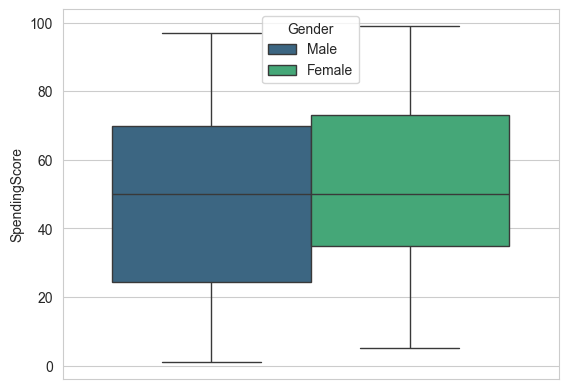

In [60]:
sns.boxplot(
    customer_set, 
    y="SpendingScore", 
    hue="Gender", 
    palette="viridis", 
)

**Висновки з завдання 5 - 8(детальні)**

5. Співвідношення чоловіків до жінок дорівнює `0.7857142857142856`. У відсотках чоловіків 44% а жінок 56%
6. Загалом по `histplot` можна сказати що прибуток чоловіків та жінок сильно не відрізняється. Також варто зазначити що згідно графіків жінки витрачають більше проте на у віці 30-35 жінок в датасеті є набагато більше ніж чоловіків що може бути причиною такого графіку.
8. Різницю у витратах видно ще краще на боксплоті жінки витрачають більше але також варто відмітити що медіана однакова що в жінок що в чоловіків.

## K-means Method ##

**Завдання 9** 

Як Ви могли помітити, вибірка, з якою ми працюємо, не містить ключової зміної з вірними мітками. Тому перед початком кластерування необхідно визначити (підібрати) оптимальну кількість кластерів на яке буде проведено розбиття. Для цього необхідно:
1. видалити змінну `Gender`, тому що ... **Чому?**;  
2. задати мінімальну та максимальну кількість кластерів самостійно;  
3. На прикладі алгоритму [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), для ознайомлення з тим як працювати в умовах коли кількість кластерів невідома заздалегіть і немає вірних міток з позначками до якого кластеру відноситься спостереження пропонується використати метод [Elbow](https://coderoad.ru/19197715/Scikit-Learn-K-Means-Elbow-criterion) (додаткові джерела: [article_1](https://medium.com/analytics-vidhya/elbow-method-of-k-means-clustering-algorithm-a0c916adc540#:~:text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.), [article_2](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/))

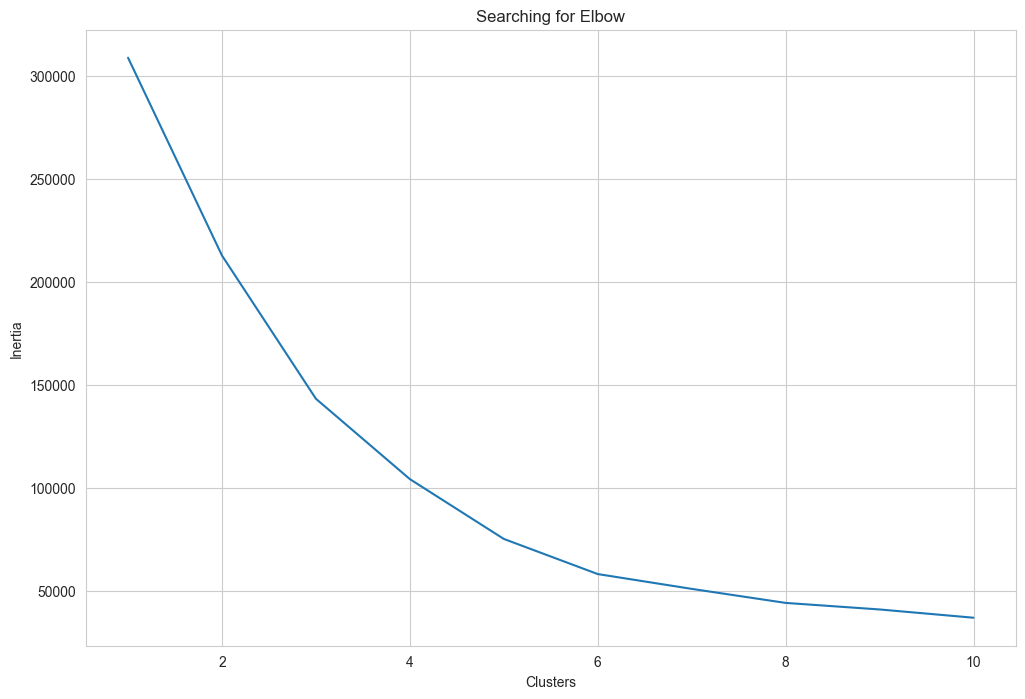

In [61]:
X = customer_set.drop(["Gender"], axis=1)
clusters = []

for i in range(1, 11):
    clusters.append(KMeans(n_clusters=i).fit(X).inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title("Searching for Elbow")
ax.set_xlabel("Clusters")
ax.set_ylabel("Inertia")


plt.show()

**Висновки з завдання 9 (детальні)** 

Атрибут `Gender` ми видалили через те що опираючись на минулі графіки ми вже знайшли потрібні нам залежності тому щоб не погіршити результати його потрібно видалити. \
В нас задано проміжок кластеризації від 1 до 10. На графіку кластерів найчіткішими ліктями є 3, 5, 6. В подальшому я буду використовувати 5 та 6 кластерів для візуалізацій.

**Завдання 10** 

Зробити двовимірну візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи змінні `Income` та `SpendingScore`. 

<Axes: xlabel='Income', ylabel='SpendingScore'>

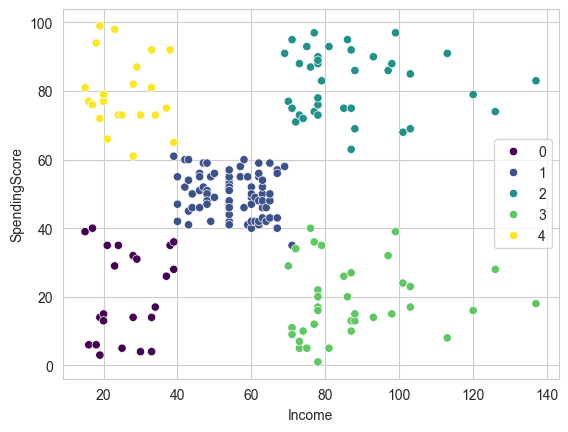

In [62]:
kmeans_5 = KMeans(n_clusters=5).fit(X)

sns.scatterplot(
    X, 
    x="Income", 
    y="SpendingScore", 
    hue=kmeans_5.labels_, 
    palette="viridis", 
)

<Axes: xlabel='Income', ylabel='SpendingScore'>

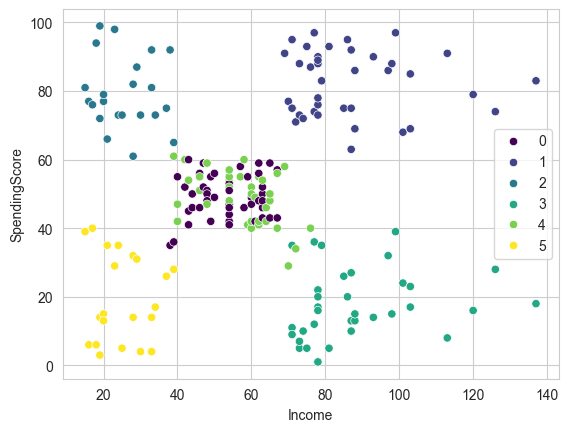

In [63]:
kmeans_6 = KMeans(n_clusters=6).fit(X)

sns.scatterplot(
    X, 
    x="Income", 
    y="SpendingScore", 
    hue=kmeans_6.labels_, 
    palette="viridis", 
)

**Завдання 11** 

Зробити візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи [scatter_3d](https://plotly.com/python/3d-scatter-plots/).

In [64]:
px.scatter_3d(
    X, 
    x="Age", 
    y="Income", 
    z="SpendingScore", 
    color=kmeans_5.labels_, 
    color_continuous_scale="viridis"
)

In [65]:
px.scatter_3d(
    X, 
    x="Age", 
    y="Income", 
    z="SpendingScore", 
    color=kmeans_6.labels_, 
    color_continuous_scale="viridis"
)

**Висновки з завдання 10 - 11 (детальні)** 

Після перегляду скатерплотів в 2д та 3д на мою думку найкращим є варіант з 5 кластерами тому що у всіх випадках він дає чітке розділення. Хоча якщо брати 3д візуалізацію тоді й 6 кластерів також розділяються рівномірно.

## Agglomerative clustering ##

Розглянемо ще один підхід до кластеризації - [агломеративну ієрархічну кластеризацію](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

**Завдання 12** 

Кластеризуйте датасет за допомогою [агломеративної ієрархічнуої кластеризації](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Мінімально необхідні параметри, що треба налаштувати:  
* `n_clusters`: параметр, який відповідає за кільксіть кластерів на яку буде проведено розбиття вибірки;  
* `linkage`: параметр зв’язку. Цей параметр визначає, яку відстань використовувати між наборами спостережень.
* перевірте як працює цей метод з різними параметрами `linkage`  
* після кожної зміни параметрів - візуалізувати розбиття на кластери

Розрахувати матрицю відстаней для нашого набору даних:
* за допомогою методу [hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) і матриці відстаней кластеризувати дані з різними значеннями параметра `method`
* за допомогою методу [hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) візуалізувати отримані результати кластеризації у вигляді дендрограм


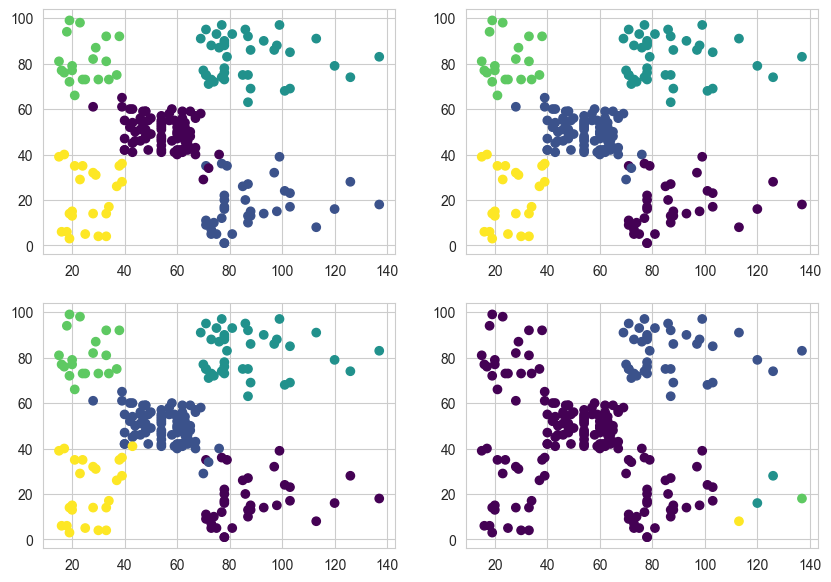

In [66]:
links = ["ward", "complete", "average", "single"]
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for i, linkage in enumerate(links):
    clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage).fit(X)


    ax[i//2, i%2].scatter(
        X["Income"], 
        X["SpendingScore"], 
        c=clustering.labels_, 
        cmap="viridis",
    )

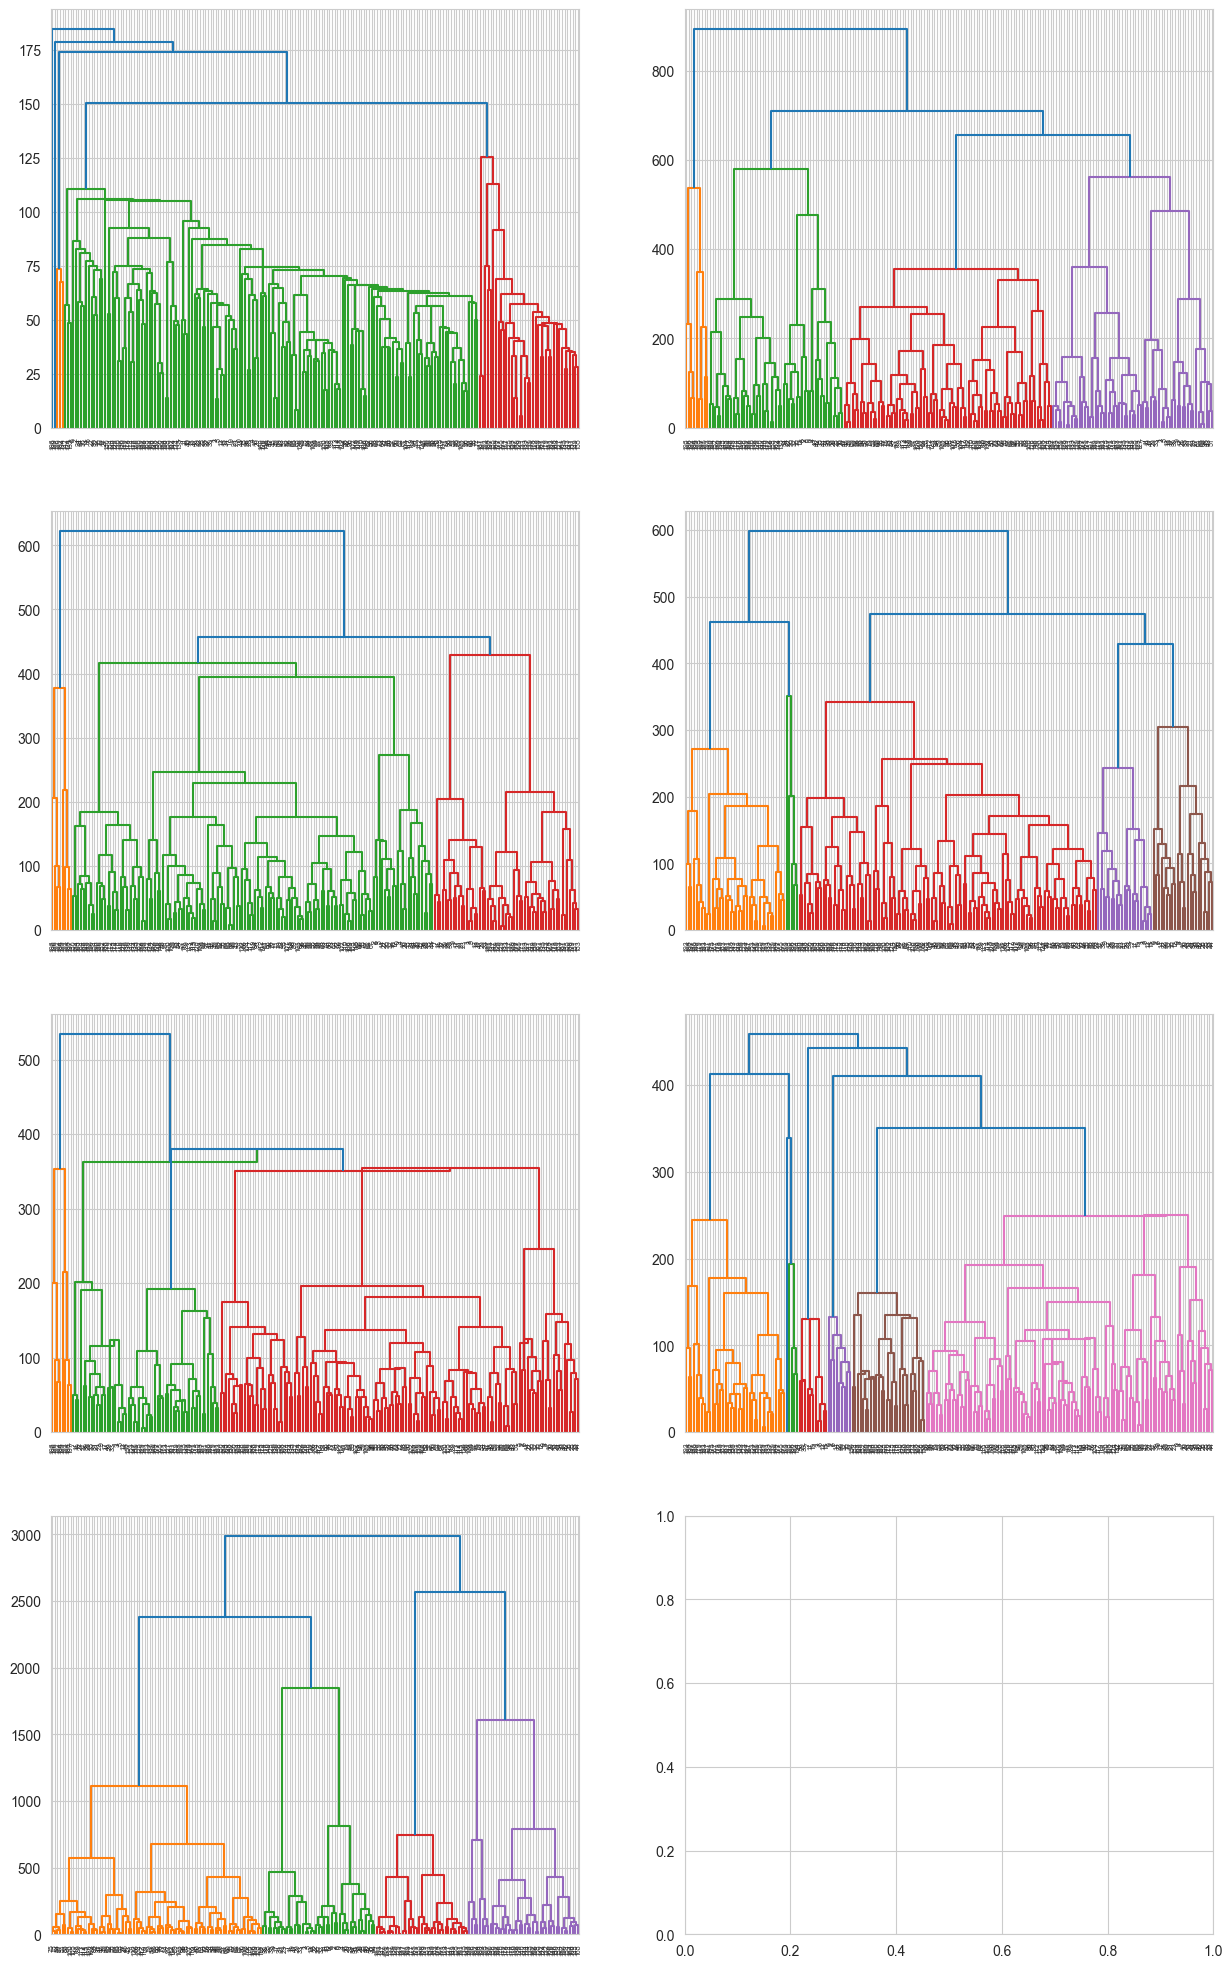

In [67]:
methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
fig, ax = plt.subplots(4, 2, figsize=(15, 25))

dist = distance_matrix(X, X)

for i, method in enumerate(methods):
    Z = hierarchy.linkage(dist, method=method)

    hierarchy.dendrogram(
        Z,
        orientation="top",
        ax=ax[i//2, i%2],
    )


**Висновки з завдання 12 (детальні)**

Найкращим методом виявився для `dendrogram` візуалізації виявився `weighted` він рівномірно обєднав всі данні у 5 кластерів

**Завдання 13** 

А тепер зробимо порівняльний аналіз отриманих результатів кластеризації розглянутими методами:  
* В фінальних візуалізаціях треба використовувати **однакову** (на вашу думку оптимальну) кількість кластерів!!!  

In [68]:
n_clusters = 5
dist = distance_matrix(X, X)


In [69]:
ac = []
for i in ["ward", "complete", "single"]:
    ac.append(AgglomerativeClustering(n_clusters=n_clusters, linkage=i))

In [70]:
kmeans = KMeans(n_clusters=n_clusters).fit(X)

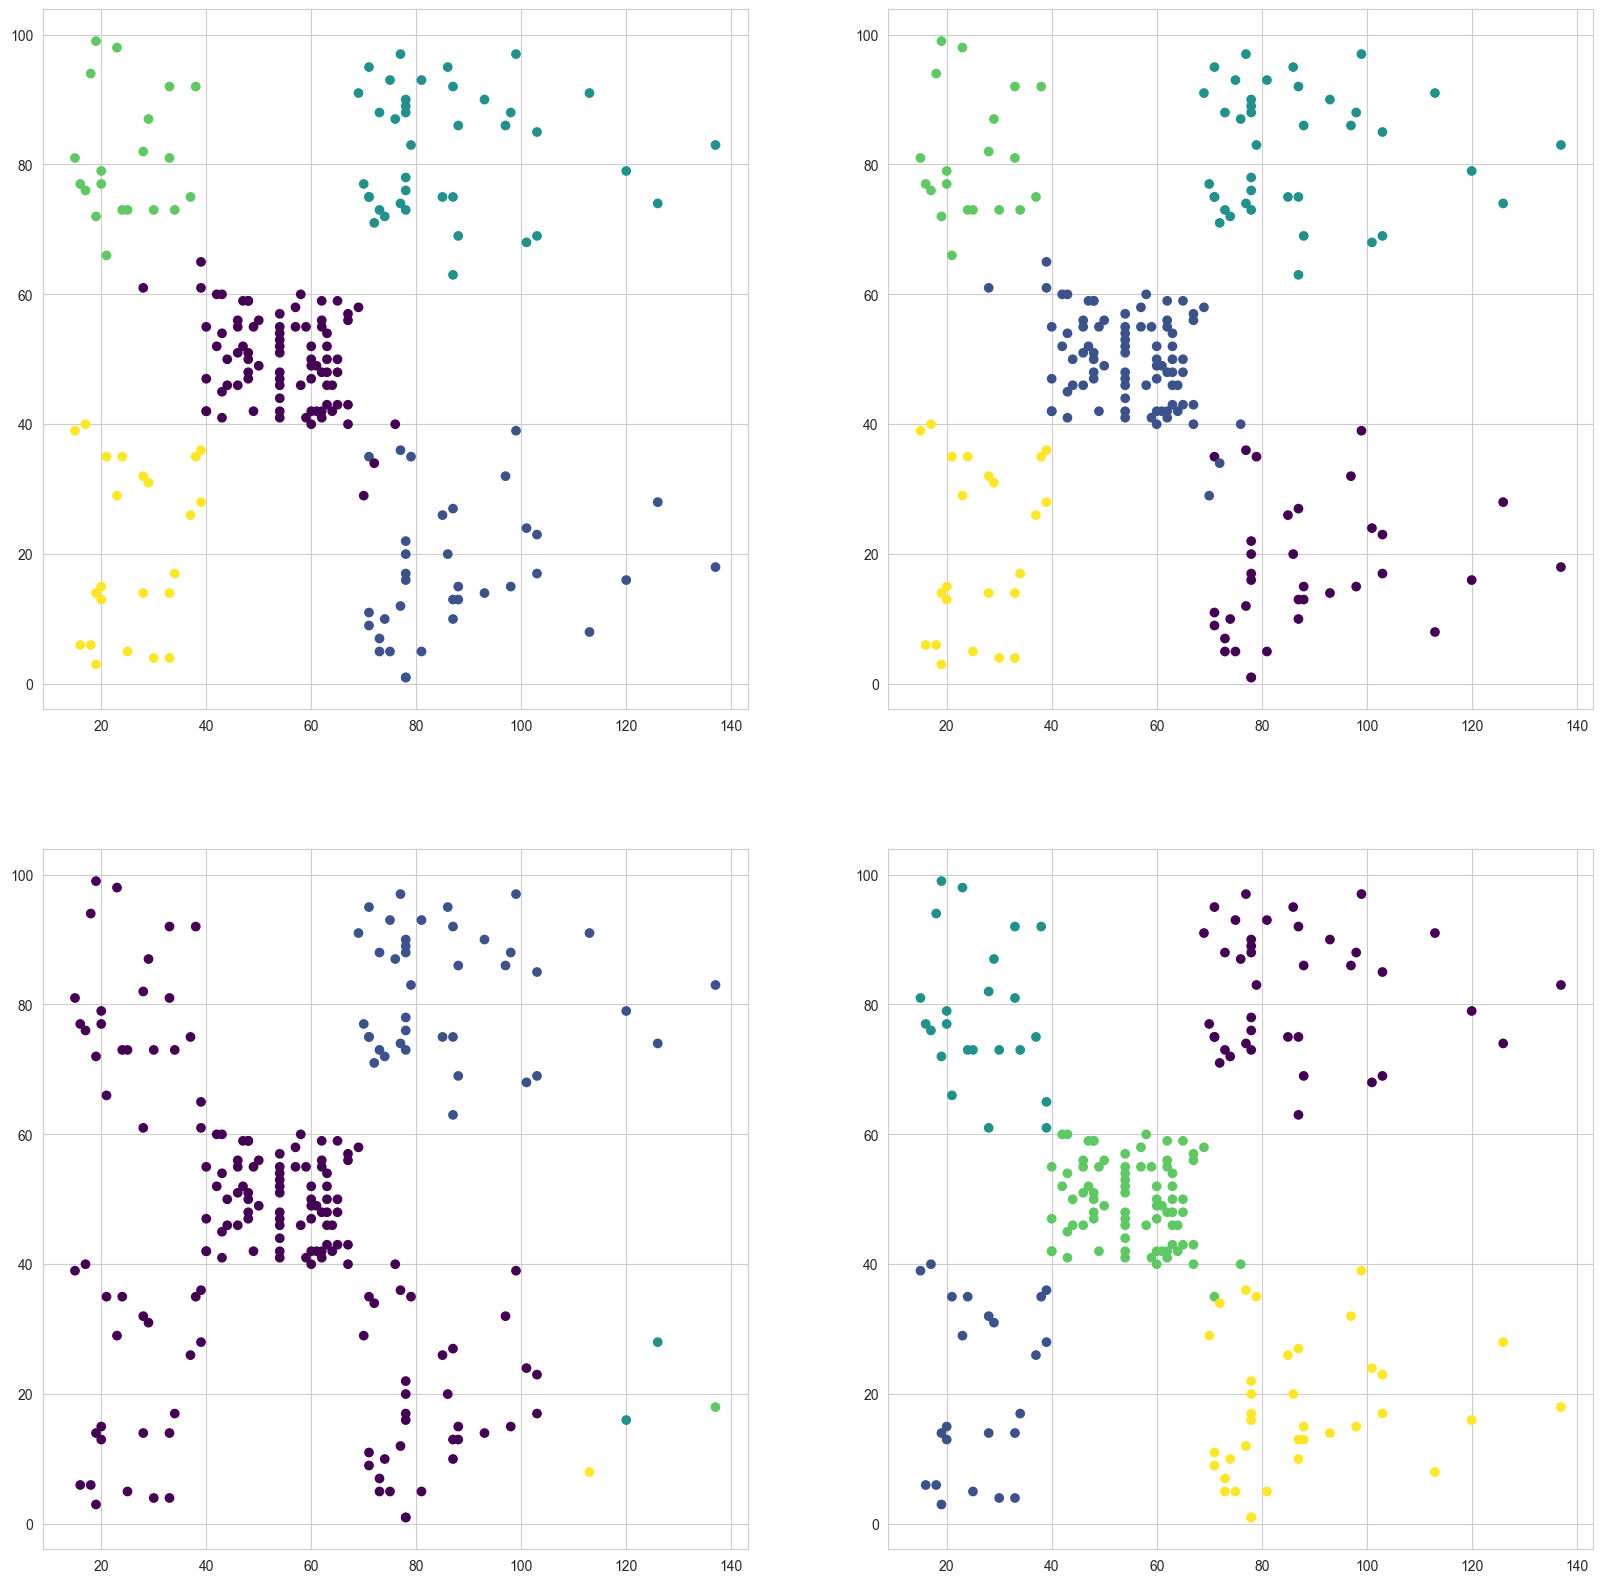

In [71]:
fig, ax = plt.subplots(2,2, figsize=(20, 20))

ax[0, 0].scatter(
    X["Income"], 
    X["SpendingScore"], 
    c=ac[0].fit_predict(X),
    cmap="viridis"
)

ax[0, 1].scatter(
    X["Income"], 
    X["SpendingScore"], 
    c=ac[1].fit_predict(X),
    cmap="viridis"
)

ax[1, 0].scatter(
    X["Income"], 
    X["SpendingScore"], 
    c=ac[2].fit_predict(X),
    cmap="viridis"
)

ax[1, 1].scatter(
    X["Income"], 
    X["SpendingScore"], 
    c=kmeans.labels_,
    cmap="viridis"
)

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75]],
 'dcoord': [[0.0, 350.52347770915856, 350.52347770915856, 0.0],
  [0.0, 379.86824799942667, 379.86824799942667, 350.52347770915856],
  [0.0, 362.6282587468427, 362.6282587468427, 379.86824799942667],
  [0.0, 535.1703481981791, 535.1703481981791, 362.6282587468427]],
 'ivl': ['(8)', '(21)', '(35)', '(28)', '(108)'],
 'leaves': [393, 390, 387, 384, 394],
 'color_list': ['C2', 'C0', 'C1', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C0', 'C2', 'C2']}

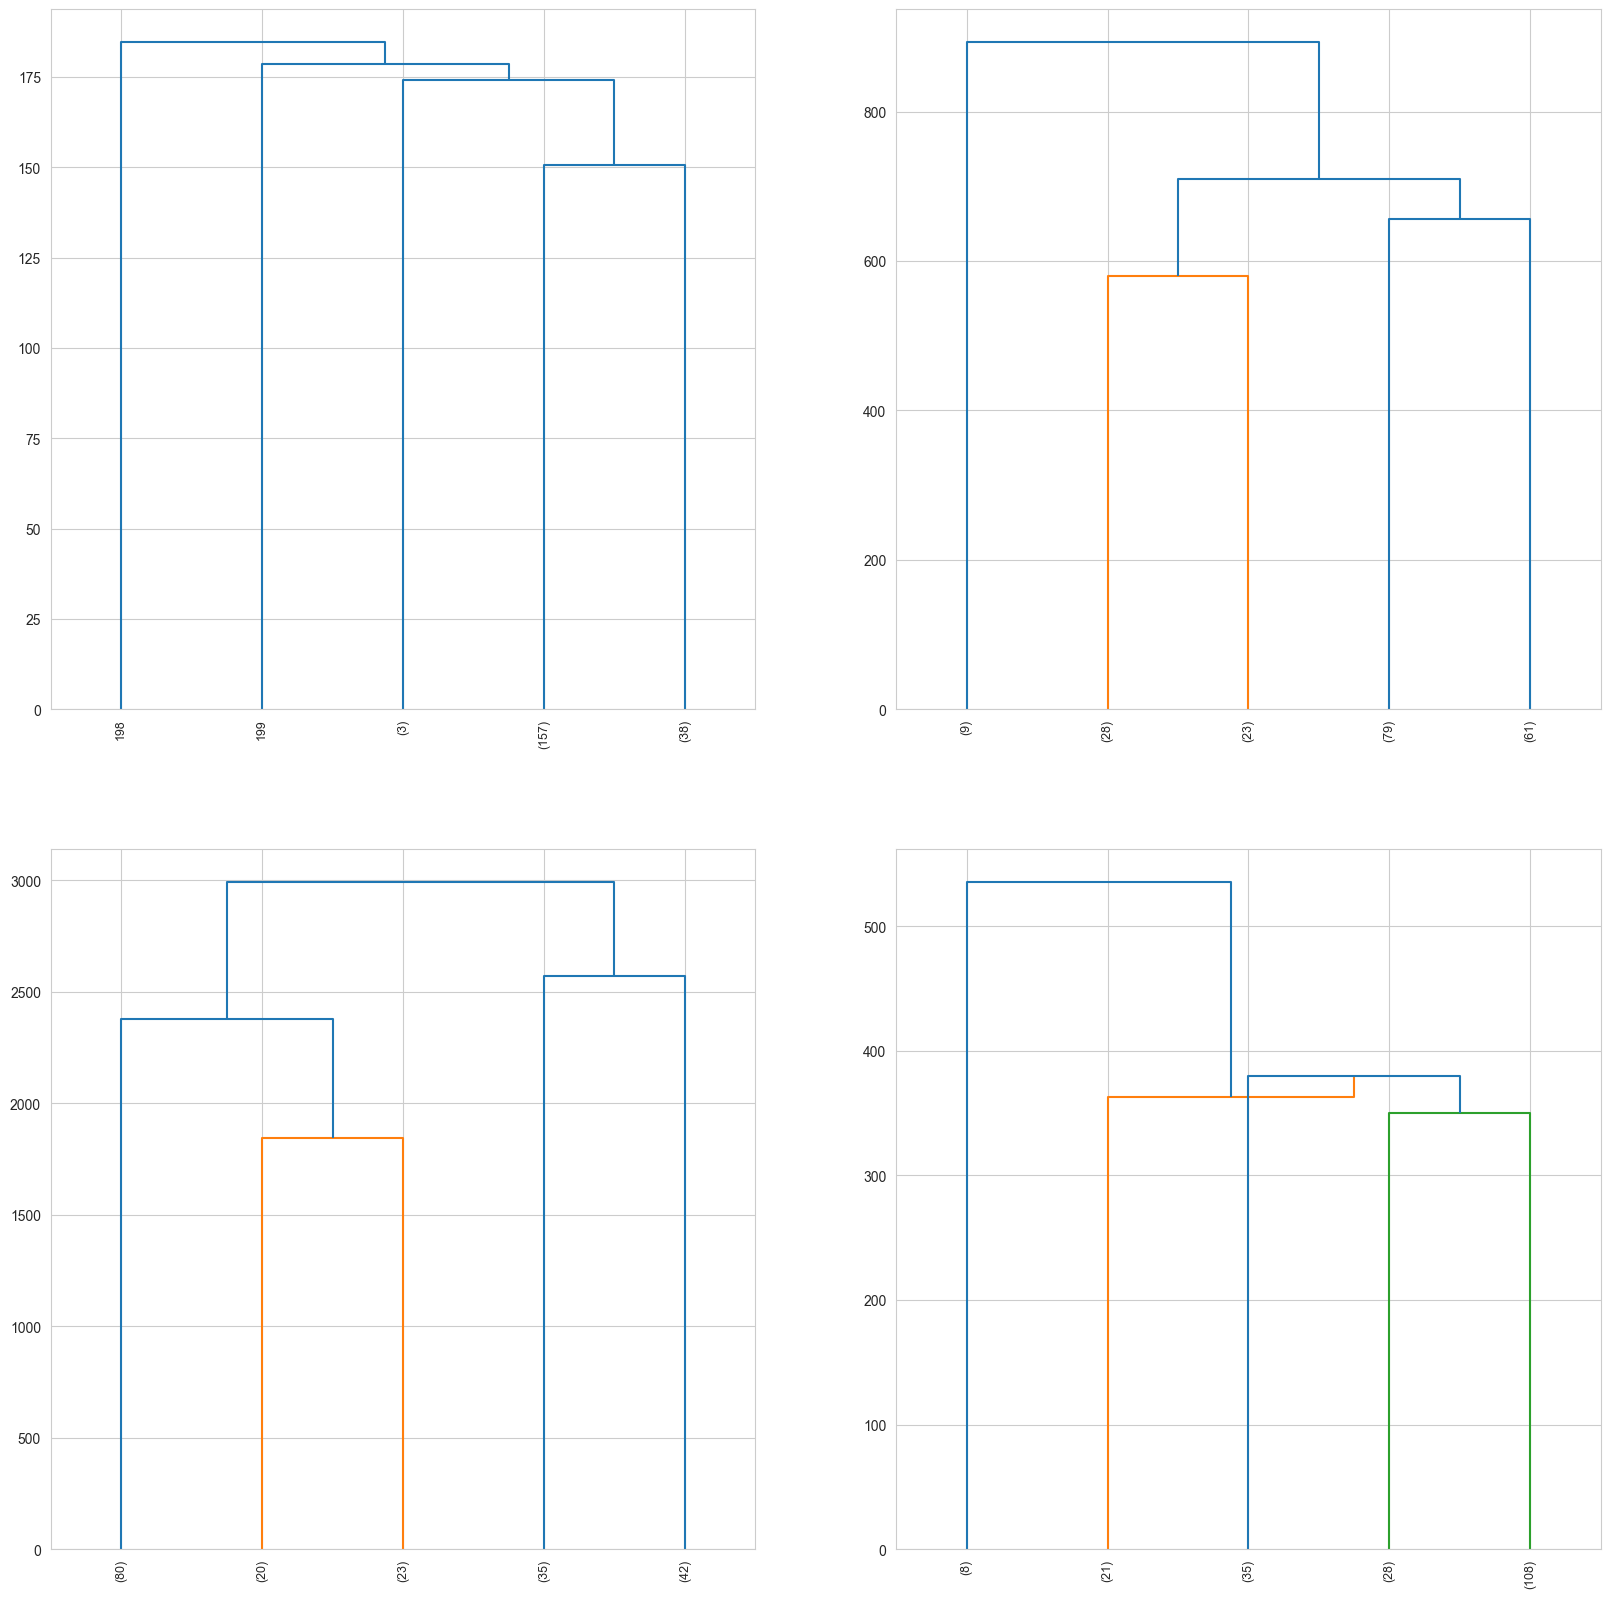

In [72]:
fig, ax = plt.subplots(2,2, figsize=(20, 20))

hierarchy.dendrogram(
    hierarchy.linkage(dist, method="single"), 
    leaf_rotation=90, 
    leaf_font_size=9, 
    orientation="top", 
    truncate_mode="lastp",
    p=5, 
    ax=ax[0,0],
)

hierarchy.dendrogram(
    hierarchy.linkage(dist, method="complete"), 
    leaf_rotation=90, 
    leaf_font_size=9, 
    orientation="top", 
    truncate_mode="lastp",
    p=5, 
    ax=ax[0,1],
)

hierarchy.dendrogram(
    hierarchy.linkage(dist, method="ward"), 
    leaf_rotation=90, 
    leaf_font_size=9, 
    orientation="top", 
    truncate_mode="lastp",
    p=5, 
    ax=ax[1,0],
)

hierarchy.dendrogram(
    hierarchy.linkage(dist, method="centroid"), 
    leaf_rotation=90, 
    leaf_font_size=9, 
    orientation="top", 
    truncate_mode="lastp",
    p=5, 
    ax=ax[1,1],
)

**Висновки з завдання 13 (детальні)**

Метод агломеративного кластеризування поступово обєднує схожі обєкти в кластери, починаючи з окремих обєктів і прогресуючи до їх обєднання у великі кластери цей процес триває до тих пір поки не буде сформований один загальний кластер або досягнута певна кількість кластерів. \

Дендрограми відображають відстані між об'єктами, допомагаючи визначити оптимальну кількість кластерів та їх структуру. \

Алгоритм KMeans випадковим чином вибирає початкові центри кластерів і потім ітеративно призначає кожен об'єкт до найближчого центру, після чого оновлює центри кластерів. У даному випадку KMeans розділив дані на 5 кластерів.